# A evolução da remuneração de servidores por sexo e raça

#### Exercício da [República.org](http://republica.org)

Vamos responder à pergunta: _"Baseado na tabela em CSV com a série histórica 'Remuneração líquida média mensal no Executivo civil federal ativo, por sexo e raça (1999-2020)', disponível no site do [Atlas do Estado Brasileiro (IPEA)](https://www.ipea.gov.br/atlasestado/filtros-series/28/vinculos-e-remuneracoes-por-sexo), comente uma ou duas tendências da evolução da remuneração destes servidores de acordo com seu sexo e/ou raça."_

In [1]:
# Carregando pacotes de Python:
import urllib.request as urlreq
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as pl

# Carregando minhas funções, criadas para este exercício:
import my_functions as my

Abaixo definimos onde os dados se encontram no servidor remoto e onde ficarão guardados localmente:

In [2]:
# Onde encontrar os dados:
url = 'https://www.ipea.gov.br/atlasestado/arquivos/downloads/5233-liquidosexoraca.csv'
local_brutos = Path('../dados/brutos/5233-liquidosexoraca.csv')
local_limpos = Path('../dados/limpos/5233-liquidosexoraca.csv')

## Baixando e preparando os dados

Essa seção só precisa ser executada uma vez. Caso os dados já tenham sido baixados e limpos, ela não é mais necessária.

### Baixando os dados

Vamos baixar os dados e salvá-los localmente. Isso evita o retrabalho futuro e garante a existência dos dados caso eles sejam apagados no servidor remoto.

In [3]:
# Baixando os dados para a pasta de dados brutos:
urlreq.urlretrieve(url, local_brutos)

(PosixPath('../dados/brutos/5233-liquidosexoraca.csv'),
 <http.client.HTTPMessage at 0x7fbedc686be0>)

### Limpando os dados

Nesta seção, limparemos os dados e os salvaremos localmente. Salvar os dados limpos evita retrabalho em caso de novas análises futuras.

In [4]:
# Carrega os dados brutos:
bruto_df = pd.read_csv(local_brutos, sep=';', index_col=0)

In [5]:
# Separa as variáveis sexo e raça:
sexo_raca_df = my.split_variables(bruto_df['sexo_raça'])

# Padroniza as categorias de raça:
sexo_raca_df['raça'] = sexo_raca_df['raça'].str.replace('(o)$', 'a')

# Converte valores líquidos para float:
liquido = my.parse_ptbr_series(bruto_df['liquido'])

In [6]:
# Junta variáveis limpas numa nova tabela:
limpo_df = pd.DataFrame()
limpo_df['ano'] = bruto_df['ano']
limpo_df = limpo_df.join(sexo_raca_df)
limpo_df['liquido'] = liquido

In [7]:
# Salva dados limpos:
limpo_df.to_csv(local_limpos)

## Análise dos dados

Nesta seção, realizamos as análises e criamos os gráficos da evolução temporal das remunerações dos diversos grupos de servidores.

In [8]:
# Carrega os dados já limpos:
remuneracao_df = pd.read_csv(local_limpos, index_col=0)

### Evolução das remunerações médias ao longo do tempo

Vamos criar um gráfico que apresente a evolução das remunerações médias dos servidores agrupados por sexo e raça.

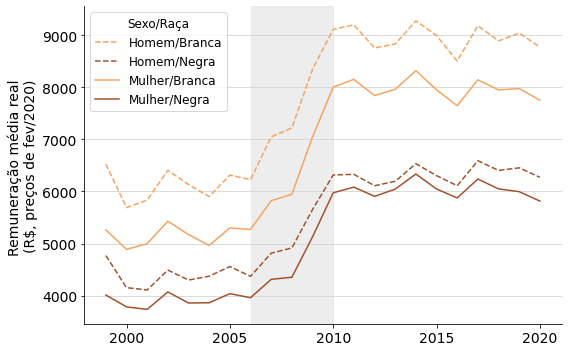

In [9]:
pl.figure(figsize=(8,5))

# Gráfico:
my.plot_timeseries(remuneracao_df, 'liquido')
# Formatação:
pl.legend(title='Sexo/Raça', fontsize=12, title_fontsize=12)
pl.ylabel('Remuneração média real \n(R$, preços de fev/2020)', fontsize=14)
# Finalização:
pl.tight_layout()
#pl.savefig('plot_evolucao_remuneracao_media_por_grupo.png')
pl.show()

**Comentários:**

* No período de 2006 a 2010, aproximadamente, houve uma forte valorização da remuneração dos servidores em geral.
* A estratificação por raça e classe é extremamente estável nesses 21 anos: homens brancos têm, em média, remunerações mais altas, seguidos das mulheres brancas, homens negros e mulheres negras. Esse padrão não foi quebrado nenhuma vez no período.
* A hierarquia de raça e de sexo são reproduzidas em todos os sub-grupos, como se fossem efeitos sobrepostos: pessoas brancas tendem a receber mais que pessoas negras, tanto entre homens quanto entre mulheres; e homens tendem a receber mais que mulheres, tanto entre negros quanto entre brancos.
* Em termos remuneratórios, a raça resulta em um efeito maior que o sexo: as diferenças entre negros e brancos é maior que a diferenças entre homens e mulheres da mesma raça. Isso coloca a remuneração média da mulher branca acima da remuneração média do homem negro.
* A diferença (no sentido matemático) entre os salários de homens e mulheres brancos permaneceu mais ou menos estável, mesmo com o aumento geral em torno de 2009. Isso fez com que as diferenças em termos percentuais (ou as razões entre os salários) ficasse menor.
* A diferença entre salários de homens e mulheres negros caiu, o que reduz a diferença em termos percentuais.
* A diferença entre salários de pessoas brancas e negras aumentou.

### Evolução das diferenças entre os grupos

Vamos calcular a razão entre as remunerações dos vários grupos, para analisarmos como que as diferenças entre elas variaram no tempo.

In [10]:
# Cria nova tabela:
razoes_remun_df = remuneracao_df

# Loop sobre grupos de servidores:
for sexo in sorted(remuneracao_df['sexo'].unique()):
    for raca in sorted(remuneracao_df['raça'].unique()):
        
        # Seleciona remunerações de um grupo como referência para os demais:
        referencia = my.extract_subset_series(remuneracao_df, sexo, raca)
        
        # Adiciona referências na tabela:
        razoes_remun_df = razoes_remun_df.join(referencia, on='ano')

# Calcula a razão entre as remunerações e as referências e adiciona na tabela:
ref_cols = razoes_remun_df.columns[-4:]                           # Seleciona colunas de referência.
razao_cols = [col.replace('ref_', 'sobre_') for col in ref_cols]  # Cria nomes para as colunas de razões.
for razao_col, ref_col in zip(razao_cols, ref_cols):
    razoes_remun_df[razao_col] = razoes_remun_df['liquido'] / razoes_remun_df[ref_col]

Agora vamos colocar as razões em gráficos:

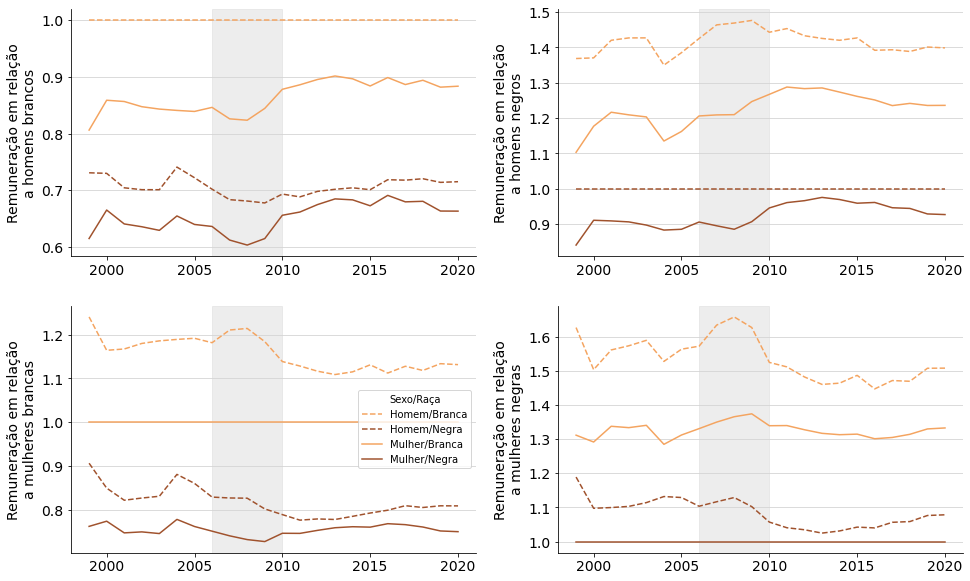

In [11]:
col_to_label = {'sobre_homem_branca': 'homens brancos',
                'sobre_homem_negra': 'homens negros',
                'sobre_mulher_branca': 'mulheres brancas',
                'sobre_mulher_negra': 'mulheres negras'}

pl.figure(figsize=(16,10))

for i, razao_col in enumerate(razao_cols):
    pl.subplot(2, 2, 1 + i)
    
    # Gráfico:
    my.plot_timeseries(razoes_remun_df, razao_col)
    # Formatação:
    if i == 2:
        pl.legend(title='Sexo/Raça', fontsize=10, title_fontsize=10, loc='center right')
    pl.ylabel('Remuneração em relação\na {}'.format(col_to_label[razao_col]), fontsize=14)
    
# Finalização:
pl.show()

**Comentários**

* A diferença salarial média em termos percentuais entre homens e mulheres caiu, principalmente em torno de 2009, tanto entre pessoas negras quanto entre pessoas brancas.
* A diferença salarial média em termos percentuais entre pessoas negras e pessoas brancas permaneceu mais ou menos constante, tanto entre homens quanto entre mulheres.
* A diferença salarial média em termos percentuais entre mulheres brancas e homens negros aumentou.

#### Gráfico para o relatório

Abaixo selecionamos o gráfico mais interessante dos acima para apresentar no texto de discussão.

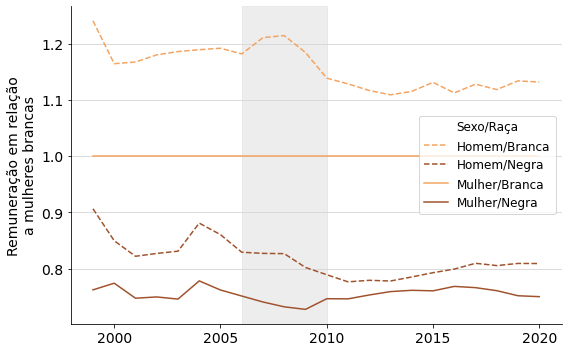

In [12]:
pl.figure(figsize=(8,5))
# Gráfico:
razao_col = 'sobre_mulher_branca'
my.plot_timeseries(razoes_remun_df, razao_col)
# Formatação:
pl.legend(title='Sexo/Raça', fontsize=12, title_fontsize=12, loc='center right')
pl.ylabel('Remuneração em relação\na {}'.format(col_to_label[razao_col]), fontsize=14)
# Finalização:
pl.tight_layout()
#pl.savefig('plot_evolucao_remuneracao_sobre_mulher_branca.png')
pl.show()